# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo



# 1. Dataset Overview and PreProcessing



### Problem Statement:
The task is to predict the probability that an online transaction is fraudulent using identity and transaction data.

### Dataset Description:
- **Target variable:** `isFraud` (1 = fraud, 0 = not fraud)
- **Files:** `train_transaction.csv`, `train_identity.csv` (joined on `TransactionID`)
- **Features:**  
  - *Transaction Data:* ProductCD, card1–card6, addr1, addr2, M1–M9  
  - *Identity Data:* DeviceType, DeviceInfo, id_12–id_38  
- The feature `TransactionDT` is a relative timestamp.


## 2. Defining all the Imports and necessary dependencies

In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.target_encoder import TargetEncoder
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression
from joblib import dump
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import Regularizer, l1, l2, l1_l2
from tensorflow.keras.optimizers import Optimizer, Adam, SGD, RMSprop,Nadam
from tensorflow.keras.callbacks import EarlyStopping

## Data PreProcessing

### 1. Loading and Merge Data

In [5]:
# Load datasets
train_transaction = pd.read_csv('data/train_transaction.csv')
train_identity = pd.read_csv('data/train_identity.csv')
test_transaction = pd.read_csv('data/test_transaction.csv')
test_identity = pd.read_csv('data/test_identity.csv')

In [6]:
# Merge on TransactionID
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_df = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

# Separate target
y = train_df['isFraud']
X = train_df.drop(columns=['isFraud', 'TransactionID'])

### 2. Outlier Clipping

In [7]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, factor=1.5):
        self.factor = factor

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        Q1 = X.quantile(0.25)
        Q3 = X.quantile(0.75)
        self.lower = Q1 - self.factor * (Q3 - Q1)
        self.upper = Q3 + self.factor * (Q3 - Q1)
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        # Clip values
        X_clipped = X.clip(lower=self.lower, upper=self.upper, axis=1)
        return X_clipped.values

### 3. Feature Grouping

In [8]:
# Identifying features by type
categorical = X.select_dtypes(include='object').columns.tolist()
numerical = X.select_dtypes(include=[np.number]).columns.tolist()

low_card = [col for col in categorical if X[col].nunique() < 10]
high_card = list(set(categorical) - set(low_card))

### 4. PreProcessing Pipeline

In [9]:
# Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('clipper', OutlierClipper()),
    ('scaler', StandardScaler())
])

low_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

high_cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', TargetEncoder())
])

# Full transformer
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical),
    ('low_cat', low_cat_pipeline, low_card),
    ('high_cat', high_cat_pipeline, high_card)
])

### 5. Data Splitting

In [10]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# variance thresholding
selector = VarianceThreshold(threshold=0.0001)
X_train_processed = selector.fit_transform(X_train_processed)
X_val_processed = selector.transform(X_val_processed)
X_test_processed = selector.transform(X_test_processed)

# SECTION 1: A Classification Model

### Light GBM Classification Model 1:
This LightGBM model is a gradient boosting classifier tailored for imbalanced fraud detection. It is trained using 5,500 boosting rounds (n_estimators) with a moderate learning rate of 0.05 to ensure stable convergence. The maximum depth is limited to 8, and 64 leaves per tree are allowed to control complexity and prevent overfitting. The class_weight='balanced' setting automatically compensates for class imbalance. It uses all available CPU cores for efficient training and sets a fixed random seed for reproducibility.

In [11]:
# A LightGBM model with tuned hyperparameters
lgb_model = lgb.LGBMClassifier(
    n_estimators=5500,# Number of boosting rounds (trees).
    learning_rate=0.05,# Step size shrinkage used to prevent overfitting.
    max_depth=8,# Maximum depth of each tree. Controls model complexity;
    num_leaves=64, # Maximum number of leaves per tree.
    class_weight='balanced',# Automatically adjusts weights inversely proportional to class frequencies, helping with class imbalance.
    random_state=42,# Sets seed for reproducibility so results are consistent across runs.
    n_jobs=-1 # Uses all available CPU cores for training (parallel processing).
)

lgb_model.fit(X_train_processed, y_train)

# Saving the trained model
dump(lgb_model, 'saved_models/lightgbm_model.joblib')

[LightGBM] [Info] Number of positive: 14464, number of negative: 398899
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.056392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4539
[LightGBM] [Info] Number of data points in the train set: 413363, number of used features: 109
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

['saved_models/lightgbm_model.joblib']

#### Model 1 Error analysis:

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


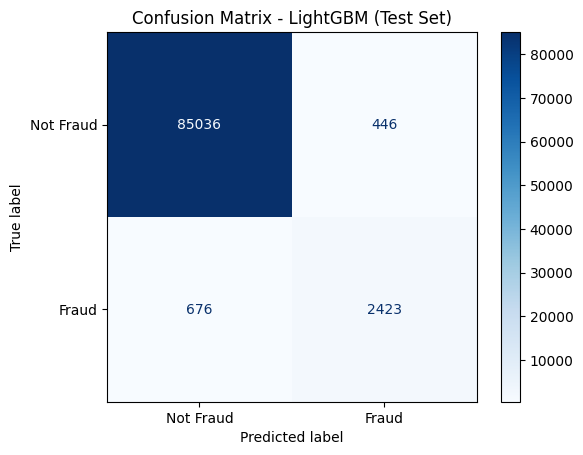

=== Classification Report (LightGBM - Test Set) ===
              precision    recall  f1-score   support

   Not Fraud       0.99      0.99      0.99     85482
       Fraud       0.84      0.78      0.81      3099

    accuracy                           0.99     88581
   macro avg       0.92      0.89      0.90     88581
weighted avg       0.99      0.99      0.99     88581

True Negatives (TN): 85036
False Positives (FP): 446
False Negatives (FN): 676
True Positives (TP): 2423


In [12]:
# Predict probabilities and convert to binary labels (Test Set)
y_test_pred_prob = lgb_model.predict_proba(X_test_processed)[:, 1]
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - LightGBM (Test Set)")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report (LightGBM - Test Set) ===")
print(report)

tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

## Model Architecture:

This is a deep neural Network Architecture that my model instances will all use each instance will have its own regularizers, optimization techiques but the core sturcture of the neural network will be the same. 6 hidden layers all usng relu activation and one output layer using sigmoid activation to classify the data into either FRAUD or NOT FRAUD.

In [21]:
def build_model(input_dim, optimizer: Optimizer = None, regularizer: Regularizer = None):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=(input_dim,), kernel_regularizer=regularizer))
    model.add(Dense(64, activation='relu', kernel_regularizer=regularizer))
    model.add(Dense(32, activation='relu', kernel_regularizer=regularizer))
    model.add(Dense(16, activation='relu', kernel_regularizer=regularizer))
    model.add(Dense(8, activation='relu', kernel_regularizer=regularizer))
    model.add(Dense(1, activation='sigmoid'))
    return model

## Task: Define a function that creates models with or without specified Optimization techniques


### Neural Network Model Instance 1:
This is the first instance of the deep neura Network with no regularizers applied and Default optimizers applied.

In [16]:
model_1 = build_model(input_dim=X_train_processed.shape[1])  # No regularizer

model_1.compile(loss='binary_crossentropy')  # Default optimizer and metrics

model_1.fit(X_train_processed, y_train, validation_data=(X_val_processed, y_val))
save_model(model_1, 'saved_models/nn_instance_1.h5')

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


12918/12918 ━━━━━━━━━━━━━━━━━━━━ 18s 1ms/step - loss: 0.1138 - val_loss: 0.1133


#### Neural Network Model Instance 1 Error analysis:

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 770us/step


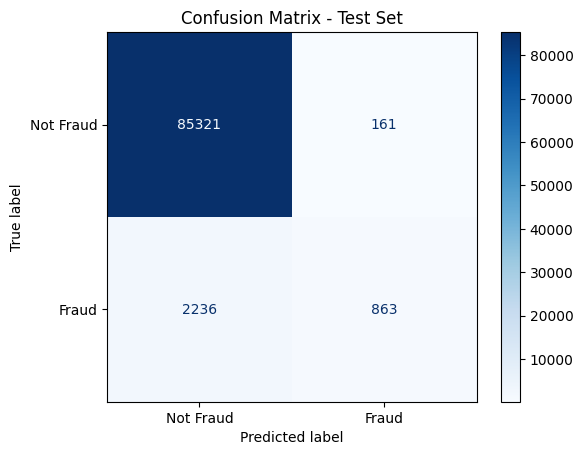

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.97      1.00      0.99     85482
       Fraud       0.84      0.28      0.42      3099

    accuracy                           0.97     88581
   macro avg       0.91      0.64      0.70     88581
weighted avg       0.97      0.97      0.97     88581

True Negatives (TN): 85321
False Positives (FP): 161
False Negatives (FN): 2236
True Positives (TP): 863


In [15]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_1.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


### Neural Network Model Instance 2:
Second instance now with my defined parameters and Hyperparameters. Used ADAM for optimization with a learning rate of 0.0001 and l2 regularization with a 0.0001 penalty also added early stopping on the valloss with a patience of 10. I also trained the model for 100 epochs with a 100 batch size.

In [ ]:
model_2 = build_model(
    input_dim=X_train_processed.shape[1],
    optimizer=Adam(learning_rate=0.0001),
    regularizer=l2(0.0001)
)

# Compile model
model_2.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit model
history_2 = model_2.fit(
    X_train_processed, y_train,
    epochs=50,
    batch_size=100,
    validation_data=(X_val_processed, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# Save model
save_model(model_2, 'saved_models/nn_instance_2.h5')

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9371 - loss: 0.1980 - val_accuracy: 0.9728 - val_loss: 0.1203
Epoch 2/50
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9734 - loss: 0.1175 - val_accuracy: 0.9739 - val_loss: 0.1151
Epoch 3/50
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9735 - loss: 0.1139 - val_accuracy: 0.9738 - val_loss: 0.1103
Epoch 4/50
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9742 - loss: 0.1095 - val_accuracy: 0.9739 - val_loss: 0.1080
Epoch 5/50
1161/4134 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9743 - loss: 0.1064

#### Neural Network Model Instance 2 Error Analysis:

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 631us/step


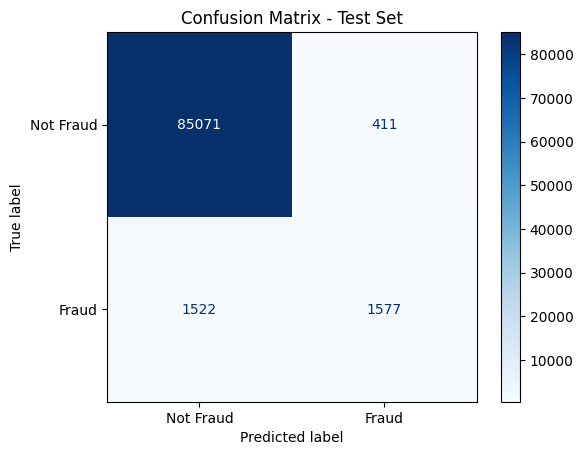

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.98      1.00      0.99     85482
       Fraud       0.79      0.51      0.62      3099

    accuracy                           0.98     88581
   macro avg       0.89      0.75      0.80     88581
weighted avg       0.98      0.98      0.98     88581

True Negatives (TN): 85071
False Positives (FP): 411
False Negatives (FN): 1522
True Positives (TP): 1577


In [54]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_2.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

### Neural Network Model Instance 3:
  A deep neural network featuring L1 regularization and Dropout decreases exponentially across its hidden layers for binary classification. It's compiled with RMSprop and trained for 100 epochs, utilized an early stopping with a larger batch size.

In [ ]:
model_3 = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_processed.shape[1],), kernel_regularizer=l1(0.0001)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation='sigmoid')
])

model_3.compile(optimizer=RMSprop(learning_rate=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_3 = model_3.fit(X_train_processed, y_train, epochs=100, batch_size=100,
                        validation_data=(X_val_processed, y_val),
                        callbacks=[early_stopping], verbose=1)

save_model(model_3, 'saved_models/nn_instance_3.h5')

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step - accuracy: 0.9615 - loss: 0.2329 - val_accuracy: 0.9723 - val_loss: 0.1453
Epoch 2/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9712 - loss: 0.1485 - val_accuracy: 0.9726 - val_loss: 0.1290
Epoch 3/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9715 - loss: 0.1330 - val_accuracy: 0.9731 - val_loss: 0.1198
Epoch 4/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9716 - loss: 0.1259 - val_accuracy: 0.9733 - val_loss: 0.1147
Epoch 5/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9721 - loss: 0.1211 - val_accuracy: 0.9729 - val_loss: 0.1130
Epoch 6/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9726 - loss: 0.1188 - val_accuracy: 0.9731 - val_loss: 0.1132
Epoch 7/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9726 - loss: 0.1172 - val_accuracy: 0.9735 - val_loss: 0.1117
Epoch 8/100
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9725 - loss: 

#### Neural Network Model Instance 3 Error Analysis:

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 694us/step


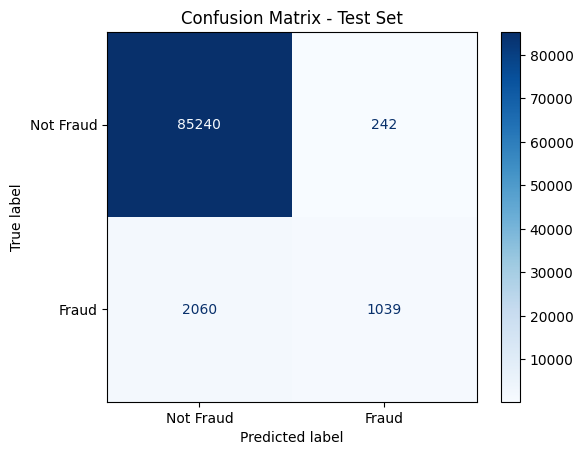

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.98      1.00      0.99     85482
       Fraud       0.81      0.34      0.47      3099

    accuracy                           0.97     88581
   macro avg       0.89      0.67      0.73     88581
weighted avg       0.97      0.97      0.97     88581

True Negatives (TN): 85240
False Positives (FP): 242
False Negatives (FN): 2060
True Positives (TP): 1039


In [61]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_3.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")

### Neural Network Model Instance 4:
A deep neural network with three hidden layers (256, 128, 64 neurons), applying L2 regularization on the first layer for binary classification. It's compiled using the SGD optimizer and trained for 30 epochs with a batch size of 64. The trained model is then saved to a file.

In [ ]:
model_4 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_processed.shape[1],), kernel_regularizer=l2(0.001)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_4.compile(optimizer=SGD(learning_rate=0.01), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history_4 = model_4.fit(X_train_processed, y_train, epochs=150, batch_size=150,
                        validation_data=(X_val_processed, y_val), callbacks=[early_stopping],verbose=1)

save_model(model_4, 'saved_models/nn_instance_4.h5')


/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9645 - loss: 0.3023 - val_accuracy: 0.9699 - val_loss: 0.2486
Epoch 2/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9699 - loss: 0.2425 - val_accuracy: 0.9714 - val_loss: 0.2281
Epoch 3/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9712 - loss: 0.2236 - val_accuracy: 0.9720 - val_loss: 0.2127
Epoch 4/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9712 - loss: 0.2103 - val_accuracy: 0.9721 - val_loss: 0.1995
Epoch 5/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9717 - loss: 0.1980 - val_accuracy: 0.9724 - val_loss: 0.1879
Epoch 6/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9722 - loss: 0.1852 - val_accuracy: 0.9726 - val_loss: 0.1776
Epoch 7/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9727 - loss: 0.1755 - val_accuracy: 0.9728 - val_loss: 0.1684
Epoch 8/150
2756/2756 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9731 - loss: 0

#### Neural Network Model Instance 4 Error Analysis:

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


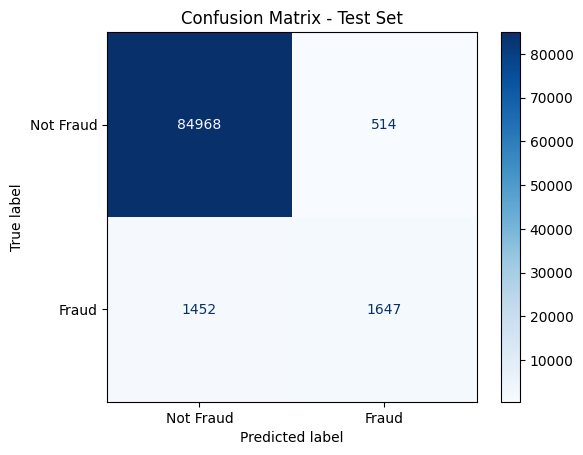

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.98      0.99      0.99     85482
       Fraud       0.76      0.53      0.63      3099

    accuracy                           0.98     88581
   macro avg       0.87      0.76      0.81     88581
weighted avg       0.98      0.98      0.98     88581

True Negatives (TN): 84968
False Positives (FP): 514
False Negatives (FN): 1452
True Positives (TP): 1647


In [65]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_4.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


### Neural Network Model Instance 5:
A deep neural network with 6 hidden layers (256, 128, 64, 32, 16 and 8 units) and integrates both L1 and L2 regularization to reduce overfitting by penalizing large weights. To further stabilize and speed up training, Batch Normalization is applied after each hidden layer. The model is compiled using the Nadam optimizer, which combines RMSProp with momentum for adaptive and efficient gradient updates. EarlyStopping is used to halt training when the validation loss stops improving, ensuring the best model is retained.

In [76]:
# Defining the model
model_5 = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_processed.shape[1],), kernel_regularizer=l1_l2(l1=1e-4, l2=1e-3)),
    BatchNormalization(),
    Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3)),
    BatchNormalization(),
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3)),
    BatchNormalization(),
    Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3)),
    BatchNormalization(),
    Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3)),
    BatchNormalization(),
    Dense(8, activation='relu', kernel_regularizer=l1_l2(l1=1e-3, l2=1e-3)),
    BatchNormalization(),
    Dense(1, activation='sigmoid')
])

# Nadam optimizer
model_5.compile(optimizer=Nadam(learning_rate = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Add EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Fit the model
history_5 = model_5.fit(X_train_processed, y_train,
                        epochs=300,
                        batch_size=100,
                        validation_data=(X_val_processed, y_val),
                        callbacks=[early_stopping],
                        verbose=1)

# Save model
save_model(model_5, 'saved_models/nn_instance_5.h5')

/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 27s 5ms/step - accuracy: 0.9328 - loss: 1.0033 - val_accuracy: 0.9672 - val_loss: 0.1294
Epoch 2/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9696 - loss: 0.1197 - val_accuracy: 0.9686 - val_loss: 0.1188
Epoch 3/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9706 - loss: 0.1138 - val_accuracy: 0.9675 - val_loss: 0.1239
Epoch 4/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9712 - loss: 0.1116 - val_accuracy: 0.9699 - val_loss: 0.1142
Epoch 5/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 17s 4ms/step - accuracy: 0.9715 - loss: 0.1105 - val_accuracy: 0.9725 - val_loss: 0.1078
Epoch 6/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9718 - loss: 0.1106 - val_accuracy: 0.9717 - val_loss: 0.1103
Epoch 7/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9710 - loss: 0.1135 - val_accuracy: 0.9717 - val_loss: 0.1084
Epoch 8/300
4134/4134 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.9711 -

#### Neural Network Model Instance 5 Error Analysis:

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


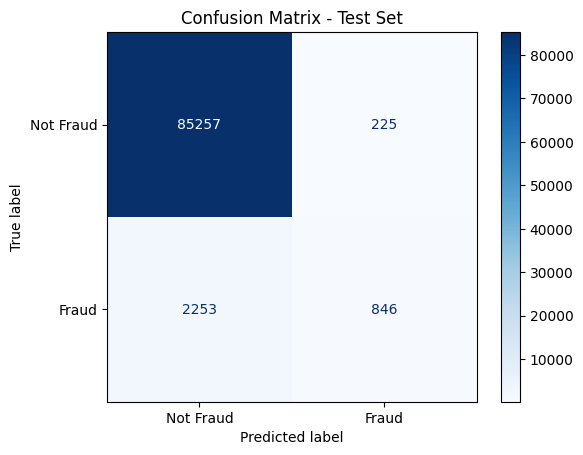

=== Classification Report ===
              precision    recall  f1-score   support

   Not Fraud       0.97      1.00      0.99     85482
       Fraud       0.79      0.27      0.41      3099

    accuracy                           0.97     88581
   macro avg       0.88      0.64      0.70     88581
weighted avg       0.97      0.97      0.97     88581

True Negatives (TN): 85257
False Positives (FP): 225
False Negatives (FN): 2253
True Positives (TP): 846


In [75]:
# Predict probabilities and convert to binary labels
y_test_pred_prob = model_5.predict(X_test_processed)
y_test_pred = (y_test_pred_prob > 0.5).astype(int).reshape(-1)
y_test_true = y_test.values.reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_test_true, y_test_pred)

# Display with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Fraud", "Fraud"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Detailed classification report
report = classification_report(y_test_true, y_test_pred, target_names=["Not Fraud", "Fraud"])
print("=== Classification Report ===")
print(report)
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"True Positives (TP): {tp}")


# Task: Print out the Final Model Accuracy and plot the Loss curve

In [77]:
def evaluate_model(y_true, y_pred_prob):
    y_pred = (y_pred_prob > 0.5).astype(int)
    return {
        'accuracy': accuracy_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred)
    }

# Get validation predictions
val_preds = {
    'Instance 1': model_1.predict(X_val_processed),
    'Instance 2': model_2.predict(X_val_processed),
    'Instance 3': model_3.predict(X_val_processed),
    'Instance 4': model_4.predict(X_val_processed),
    'Instance 5': model_5.predict(X_val_processed),
    'Instance 6': lgb_model.predict_proba(X_val_processed)[:, 1],
}

# Get test predictions
test_preds = {
    'Instance 1': model_1.predict(X_test_processed),
    'Instance 2': model_2.predict(X_test_processed),
    'Instance 3': model_3.predict(X_test_processed),
    'Instance 4': model_4.predict(X_test_processed),
    'Instance 5': model_5.predict(X_val_processed),
    'Instance 6': lgb_model.predict_proba(X_test_processed)[:, 1],
}

# Evaluate
val_results = {k: evaluate_model(y_val, v) for k, v in val_preds.items()}
test_results = {k: evaluate_model(y_test, v) for k, v in test_preds.items()}

# Function to print results
def print_results(title, results):
    print(f"\n=== {title} ===")
    print(f"{'Instance':<12} {'Accuracy':<10} {'F1 Score':<10} {'Precision':<10} {'Recall':<10}")
    print("=" * 60)
    for instance, metrics in results.items():
        print(f"{instance:<12} "
              f"{metrics['accuracy']:<10.4f} "
              f"{metrics['f1']:<10.4f} "
              f"{metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f}")

# Print both results
print_results("Validation Set Evaluation", val_results)
print_results("Test Set Evaluation", test_results)

2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 761us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 725us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 625us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 794us/step


/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 826us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 746us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 2s 722us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 3s 980us/step
2769/2769 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


/Users/irakizagaius/Downloads/FraudDetection/.venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


ValueError: Found input variables with inconsistent numbers of samples: [88581, 88596]

# SECTION 3: Predictions on The Best Model
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [ ]:
def make_predictions(model_path, X):

    # Load the model
    model = load_model(None)
    # Make predictions
    predictions = None
    # Convert probabilities to binary labels (0 or 1)

    return predictions

#Modify the code appropriately

In [ ]:
model_path = None
make_predictions(None)